## Aprendizaje por Refuerzo 1
### Carrera de Especialización en Inteligencia Artificial - FIUBA

### Trabajo Final

### 3º Bimestre 2025

### Grupo

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Braian Desía          | b.desia@hotmail.com       | a1804   |

## Double Deep Q-Learning Network aplicado a stock trading

### 1. DESCRIPCIÓN DEL DESAFÍO

Se presenta la implementación de un **agente** entrenado mediante técnicas de Reinforcement Learning (RL), específicamente utilizando la técnica *Double Deep Q-Learning Network* (DDQN), para la toma de decisiones en el contexto del trading de acciones. Este proyecto busca demostrar la aplicación práctica de RL en un entorno financiero dinámico, donde el agente debe aprender a maximizar su rentabilidad a través de la interacción con un mercado simulado a partir de datos históricos.

El objetivo principal es desarrollar un agente capaz de tomar decisiones óptimas de inversión (hold, buy or sell) en un mercado de acciones, basándose únicamente en la observación de datos históricos de precios y un conjunto de indicadores técnicos. Este entorno financiero presenta desafíos como la volatilidad de los precios, las comisiones de transacción, el spread de compra/venta y la necesidad de gestionar un capital limitado. El agente utiliza RL para aprender una política óptima mediante la exploración y explotación, ajustándose a patrones no lineales y adaptándose a cambios en el mercado sin requerir suposiciones previas sobre la distribución de los datos.

El entorno ha sido diseñado de forma personalizada utilizando la librería Gymnasium. Este entorno simula un mercado de acciones con datos históricos de precios de cierre, integrando variables como el saldo disponible, las acciones en posesión y un conjunto de indicadores técnicos (e.g., medias móviles exponenciales, RSI). El agente recibe recompensas basadas en la variación de su patrimonio neto, con penalizaciones por inactividad, incentivando así un comportamiento estratégico y eficiente.

### 2. IMPLEMENTACIÓN

#### 2.1 LIBRERÍAS

In [1]:
import gymnasium as gym
import gymnasium.utils.seeding as seeding
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os

#### 2.2 DATA

Se toma como caso testigo la acción de APPLE. Se aplica la API de Yahoo Finances para obtener los datos intradiarios de los últimos 10 años.

In [ ]:
TICKET = 'AAPL'  # Apple Inc.

datafolder = 'Data'
datafile = os.path.join(datafolder, f'{TICKET}_stock_data.xlsx')

if os.path.exists(datafile):
    # Si el archivo existe, cargarlo
    data = pd.read_excel(datafile)
    data = data.set_index('Date')
    print("Archivo encontrado y cargado desde disco.")
else:
    # Si no existe, descargar y guardar
    data = yf.download(TICKET, start='2015-01-01', end='2025-08-20')
    if not os.path.exists(datafolder):
        os.makedirs(datafolder)
    data.to_excel(datafile)
    print("Datos descargados y guardados en el archivo.")

Archivo encontrado y cargado desde disco.


In [3]:
data.head()

,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.261049,24.729272,23.821673,24.718176,212818400
2015-01-05,23.577581,24.110158,23.391181,24.030271,257142000
2015-01-06,23.579788,23.839418,23.218079,23.641922,263188400
2015-01-07,23.910435,24.010292,23.677432,23.788385,160423600
2015-01-08,24.829128,24.886824,24.121246,24.238858,237458000


In [4]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-08-13,233.330002,235.000000,230.429993,231.070007,69878500
2025-08-14,232.779999,235.119995,230.850006,234.059998,51916300
2025-08-15,231.589996,234.279999,229.339996,234.000000,56038700
2025-08-18,230.889999,233.119995,230.110001,231.699997,37476200
2025-08-19,230.559998,232.869995,229.350006,231.279999,39320800


Se divide el set en train/test usando una relación 80/20, respectivamente. Dado que se trata de una serie de tiempo, se respeta la cronología de datos en la división del set asegurando que el agente se evalúe en datos "futuros" no vistos durante el entrenamiento.

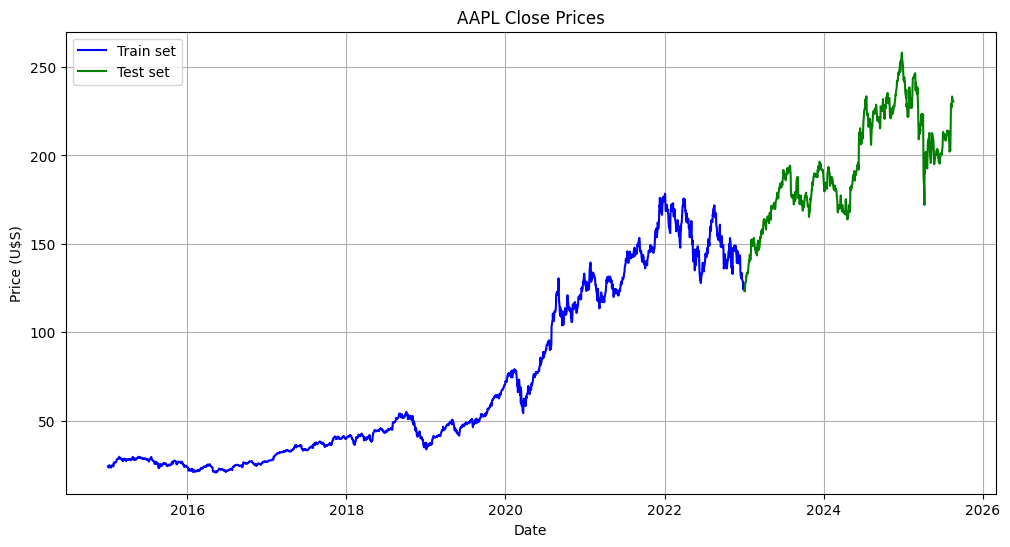

In [5]:
# Dividir en entrenamiento y prueba

split_date = '2023-01-01'  # Fecha de corte para entrenamiento/prueba

train_data = data[data.index < split_date]
test_data = data[data.index >= split_date]
train_prices = train_data['Close'].values
test_prices = test_data['Close'].values

# Gráficos de los datos (combinados en uno solo)
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_prices, label='Train set', color='blue')
plt.plot(test_data.index, test_prices, label='Test set', color='green')
plt.title(f'{TICKET} Close Prices')
plt.xlabel('Date')
plt.ylabel('Price (U$S)')
plt.legend()
plt.grid(True)
plt.show()

#### 2.3 ENVIRONMENT SETUP

Primeramente definimos algunas funciones para calcular indicadores técnicos para informar el estado del agente.

In [6]:
# DEFINIMOS ALGUNAS FUNCIONES AUXILIARES PARA ANÁLISIS TÉCNICO

# Función para calcular RSI
def calculate_rsi(prices, period=14):
    if len(prices) < period + 1:
        return 50.0  # Neutral si no hay suficientes datos
    deltas = np.diff(prices)
    gains = deltas.copy()
    losses = deltas.copy()
    gains[gains < 0] = 0
    losses[losses > 0] = 0
    avg_gain = np.mean(gains[-period:])
    avg_loss = np.abs(np.mean(losses[-period:]))
    if avg_loss == 0:
        return 100.0
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# Función para calcular EMA
def calculate_ema(prices, period=14):
    if len(prices) < period:
        return 0.0
    prices_window = prices[-period:]
    alpha = 2 / (period + 1)
    ema = prices_window[0]
    for price in prices_window[1:]:
        ema = alpha * price + (1 - alpha) * ema
    return ema

# Función para calcular SMA
def calculate_sma(prices, period=14):
    return np.mean(prices[-period:]) if len(prices) >= period else 0.0

# Función para calcular la tasa de variación promedio del precio en un período
def calculate_avg_rate(prices, period=14):
    if len(prices) < period + 1:
        return 0.0
    prices_window = prices[-(period + 1):]
    # Calcular las variaciones
    rates = np.diff(prices_window)
    # Retornar la media de las tasas de variación
    return np.mean(rates)


Para la generación del ambiente personalizado, se define una clase personalizada `TradingEnv` que hereda de `gym.Env`. Los parámetros principales incluyen:

- *Ventana de observación:* 30 por default. Define la ventana de precios hacia atrás que se le va a informar al agente en cada estado para que tome decisiones.

- *Capital inicial:* $10,000 por default. Define el monto inicial de liquidez para que el agente opere en el mercado de acuerdo a la política que vaya definiendo.

- *Indicadores técnicos:* Medias móviles exponenciales (EMA6 y EMA21 para corto plazo, EMA50 para mediano plazo), simples (SMA100, EMA200 para mediano y largo plazo respectivamente) y el RSI. Forman parte del set de información que define al estado en un instante dado en conjunto con los datos de la ventana de observación.

- *Espacio de observación:* Vector de longitud igual a la ventana de precios + cantidad de indicadores técnicos considerados, continuo e ilimitado.

- *Espacio de acciones:* Discreto con 3 opciones (0: hold, 1: buy, 2: sell).

- *Operaciones:* Cada buy/sell opera un porcentaje fijo (10%) del capital inicial, con penalizaciones por comisiones (0.1%) y spreads (0.5%). Esas penalizaciones implicitamente desalientan a tomar movimientos innecesarios. Por otra parte, se penaliza mantenerse quieto desalentando que el agente no haga movimientos.

- *Recompensa:* Diferencia en valor neto (balance + shares * precio actual), penalizando implícitamente trades frecuentes por costos. Se normaliza respecto del balance inicial para mejorar el entrenamiento.

- *Reset*: Método que reinicia los parámetros del agente para dar inicio a un nuevo episodio.

- *Step*: Método que actualiza la información del entorno; avanza un paso por día, terminando al final de la serie.

- *_get_obs*: Método que devuelve el estado del ambiente en un instante dado para que el agente ejecute acciones, combinando precios e indicadores para la toma de decisiones.

In [7]:
class TradingEnv(gym.Env):
    def __init__(self, stock_data, window_size=30, initial_balance = 10_000):
        
        self.dates = stock_data.index                   # Fecha
        self.prices = stock_data['Close'].values        # Precio al cierre

        self.window_size = window_size                  # Tamaño de la ventana de observación

        self.initial_balance = initial_balance          # Capital inicial
        self.cap_by_op = 0.10                           # Fracción del capital a invertir por operación
        self.commission = 0.001                         # Comisión de inversión por operación y comisión
        self.spread = 0.005                             # Spread de compra/venta. Se divide mitad para compra y venta respecto del valor medio
        
        self.current_step = window_size                 # Setea el inicio en la ventana de observación
        self.balance = self.initial_balance     
        self.shares_held = 0                            # Acciones en posesión 
        
        self.action_space = gym.spaces.Discrete(3)      # 0: Hold, 1: Buy, 2: Sell
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(window_size + 8,)) # Ventana de precios + indicadores técnicos
        
        self.render_flag = False
        self.render_df = pd.DataFrame()
        
    def seed(self, seed=None):
        """
        Set the seed for reproducibility in Gymnasium.
        """
        self.np_random, seed1 = seeding.np_random(seed)
        return [seed1]
        
    def reset(self):
        self.current_step = self.window_size
        self.balance = self.initial_balance
        self.shares_held = 0
        return self._get_obs()

    def step(self, action):
        current_price = self.prices[self.current_step]                   # Precio actual
        prev_price = self.prices[self.current_step - 1]                  # Precio día anterior
        prev_net_worth = self.balance + self.shares_held * prev_price       # Patrimonio neto previo = CAJA + ACCIONES AL DÍA ANTERIOR

        amount_to_trade = self.initial_balance * self.cap_by_op             # Cantidad de dinero a operar
        shares_to_trade = int((amount_to_trade / current_price).item())     # Cantidad de acciones a operar
        if action == 1:  # Buy
            buy_cost_factor = 1 + self.commission + 0.5 * self.spread
            total_buy_cost = shares_to_trade * current_price * buy_cost_factor
            if self.balance >= total_buy_cost:
                self.shares_held += shares_to_trade
                self.balance -= total_buy_cost
            else:
                shares_to_trade = 0
        elif action == 2 and self.shares_held >= 0:  # Sell
            shares_to_trade = min(shares_to_trade, self.shares_held)  # No vender más de lo disponible
            sell_income_factor = 1 - self.commission - 0.5 * self.spread
            total_sell_income = shares_to_trade * current_price * sell_income_factor
            self.shares_held -= shares_to_trade
            self.balance += total_sell_income
        
        net_worth = self.balance + self.shares_held * current_price         # Patrimonio neto actual
        reward = (net_worth - prev_net_worth) / self.initial_balance        # Recompensa = Diferencia de Balance entre pasos relativo al balance inicial
        
        # Penalización por inactividad
        if action == 0:
            reward -= 0.1 * abs(reward)
        if self.render_flag:
            self.render(action, shares_to_trade)
        
        self.current_step += 1                                              # Actualiza el paso
        done = self.current_step >= len(self.prices)
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        prices_window = self.prices[self.current_step - self.window_size:self.current_step].flatten()
        prices_window_365 = self.prices[max(0, self.current_step - 365):self.current_step].flatten()
        max_price = np.max(prices_window) if len(prices_window) > 0 and np.max(prices_window) != 0 else 1.0
        max_price_365 = np.max(prices_window_365) if len(prices_window_365) > 0 and np.max(prices_window_365) != 0 else 1.0
        prices_window_norm = prices_window / max_price
        # Calcular indicadores técnicos
        ema8 = calculate_ema(prices_window, period=8) / max_price                   # Corto plazo
        ema21 = calculate_ema(prices_window, period=21) / max_price                 # Corto plazo
        ema50 = calculate_ema(prices_window_365, period=50) / max_price_365         # Mediano plazo
        sma100 = calculate_sma(prices_window_365, period=100) / max_price_365       # Mediano plazo
        sma200 = calculate_sma(prices_window_365, period=200) / max_price_365       # Largo plazo
        rsi = calculate_rsi(prices_window) / 100.0              # RSI normalizado a [0, 1]
        initial_max_shares = int(self.initial_balance / self.prices[self.window_size])
        position = np.array([self.balance / self.initial_balance, self.shares_held / initial_max_shares])
        indicators = np.array([ema8, ema21, ema50, sma100, sma200, rsi, position[0], position[1]], dtype=np.float32)
        return np.concatenate((prices_window_norm, indicators)).astype(np.float32)

    
    def render(self, action, shares_amount):
        current_date = self.dates[self.current_step]
        
        if action == 1:
            today_action = 'buy'
        elif action == 2:
            today_action = 'sell'
        else:
            today_action = 'hold'
        
        current_price = self.prices[self.current_step]
        
        step_df = pd.DataFrame({
            'date': [current_date],
            'balance': [self.balance],
            'shares_held': [self.shares_held],
            'price': [current_price],
            'action': [today_action],
            'shares_amount': [shares_amount]
        })
        
        self.render_df = pd.concat([self.render_df, step_df], ignore_index=True)
    
    def render_all(self):
        df = self.render_df.set_index('date')       
        fig, ax = plt.subplots(figsize=(18, 6)) 
        df.plot( y="balance" , use_index=True,  ax = ax, style='--' , color='lightgrey') 
        df.plot( y="price" , use_index=True,  ax = ax , secondary_y = True , color='black')

        for idx in df.index.tolist():
            if (df.loc[idx]['action'] == 'buy') & (df.loc[idx]['shares_amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] - 1,
                    'g^'
                )
                plt.text(idx, df.loc[idx]["price"]- 3, df.loc[idx]['shares_amount'] , c= 'green',fontsize=8, horizontalalignment='center', verticalalignment='center')
            elif (df.loc[idx]['action'] == 'sell') & (df.loc[idx]['shares_amount'] > 0):
                plt.plot(
                    idx,
                    df.loc[idx]["price"] + 1,
                    'rv'
                    )
                plt.text(idx, df.loc[idx]["price"] + 3, df.loc[idx]['shares_amount'], c= 'red',fontsize=8, horizontalalignment='center', verticalalignment='center')        

#### 2.4 REINFORCED LEARNING MODEL

El agente se implementa en la clase `DDQNAgent`, usando PyTorch:

- *Redes neuronales:* Dos DQN (principal y objetivo), cada una con capas de 128-128-3 neuronas y activación ReLU.

- *Act:* Epsilon-greedy para seleccionar acción, con decaimiento de epsilon exponencial para reducir la exploración y explotar la política aprendida a medida que avanzan los episodios de entrenamiento.

- *Replay:* Experience replay con minibatch; calcula Q objetivo usando target_model para estabilidad. Se ejecuta cada cierta cantidad de pasos para disminuir costo computacional.

- *Remember:* Almacena transiciones de experiencia.

- *Update target*: Sincroniza la red objetivo cada cierta cantidad de episodios.

El entrenamiento ocurre en 2000 episodios, donde cada episodio recorre la serie de precios de entrenamiento, acumulando recompensas y actualizando la red vía Adam optimizer y MSE loss.

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import os

# Fijar seed para reproducibilidad
seed = 42  # Puedes cambiar este valor, pero manténlo fijo para repeticiones
os.environ['PYTHONHASHSEED'] = str(seed)  # Para hash consistency
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # Si usas GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
buffer_size = 10_000  # Tamaño del buffer de memoria

# Red Neuronal Q
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# Agente DDQN (Enfoque Double DQN con replay buffer, target network)
class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.batch_size = 64
        # Inicializar modelos
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.target_model.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # --- Método para actualizar la Red Objetivo --
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    # --- Método para ejecutar una acción --
    def act(self, state):       # Epsilon-greedy action selection
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)   # Exploración 
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state)
            return np.argmax(act_values.detach().numpy())

    # --- Replay Buffer ---
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        
        states = torch.FloatTensor(np.array(states))
        next_states = torch.FloatTensor(np.array(next_states))
        actions = torch.LongTensor(actions).unsqueeze(1)
        rewards = torch.FloatTensor(rewards)
        dones = torch.FloatTensor(dones)

        Q_expected = self.model(states).gather(1, actions).squeeze()

        # --- INICIO DE LA MODIFICACIÓN DOUBLE DQN ---
        with torch.no_grad():
            # 1. Selecciona las acciones con la red principal u ONLINE
            next_actions = self.model(next_states).max(1)[1].unsqueeze(1)
            # 2. Calcula los valores Q de las acciones seleccionadas con la red TARGET
            Q_targets_next = self.target_model(next_states).gather(1, next_actions).squeeze()

        # --- FIN DE LA MODIFICACIÓN DOUBLE DQN ---

        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        loss = self.criterion(Q_expected, Q_targets.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

#### 2.5 TRAINING

Episodio 0, Recompensa total: -1304.4, Acciones: {0: 687, 1: 629, 2: 668}, Epsilon: 1.00
Episodio 50, Recompensa total: -699.2, Acciones: {0: 664, 1: 667, 2: 653}, Epsilon: 0.92
Episodio 100, Recompensa total: 5294.3, Acciones: {0: 646, 1: 672, 2: 666}, Epsilon: 0.85
Episodio 150, Recompensa total: 1421.9, Acciones: {0: 530, 1: 712, 2: 742}, Epsilon: 0.78
Episodio 200, Recompensa total: 6486.6, Acciones: {0: 611, 1: 724, 2: 649}, Epsilon: 0.72
Episodio 250, Recompensa total: 1504.8, Acciones: {0: 543, 1: 810, 2: 631}, Epsilon: 0.66
Episodio 300, Recompensa total: -681.6, Acciones: {0: 707, 1: 647, 2: 630}, Epsilon: 0.61
Episodio 350, Recompensa total: -6252.8, Acciones: {0: 548, 1: 748, 2: 688}, Epsilon: 0.56
Episodio 400, Recompensa total: 3153.0, Acciones: {0: 512, 1: 773, 2: 699}, Epsilon: 0.52
Episodio 450, Recompensa total: 8558.0, Acciones: {0: 451, 1: 600, 2: 933}, Epsilon: 0.48
Episodio 500, Recompensa total: -1864.0, Acciones: {0: 528, 1: 869, 2: 587}, Epsilon: 0.44
Episodio 5

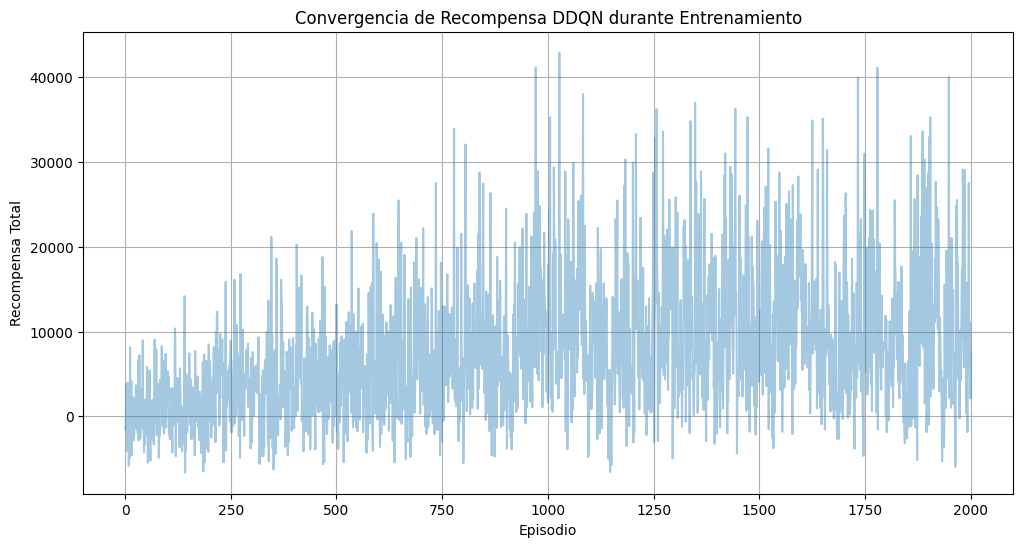

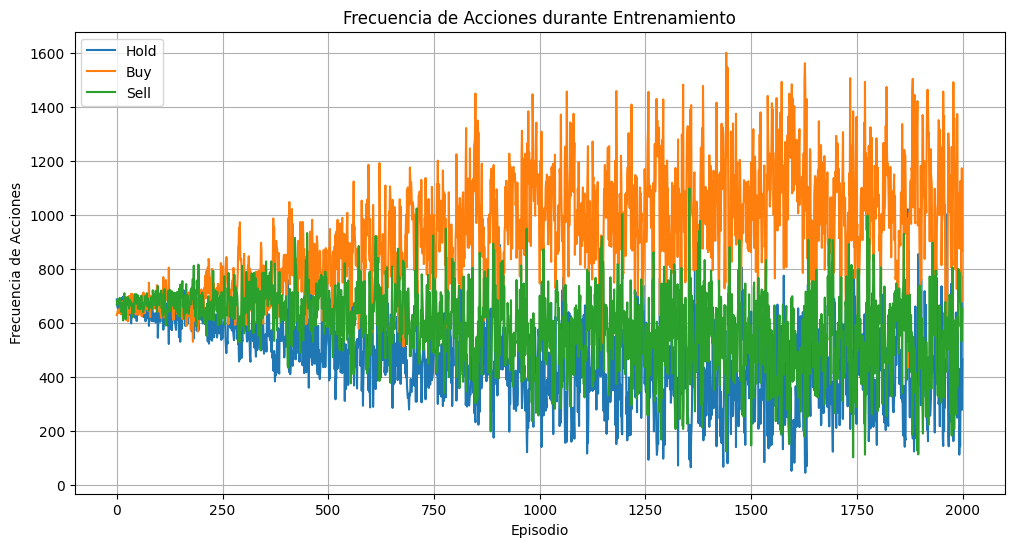

In [ ]:
# HIPERPARÁMETROS

episodes = 2_000

target_update_freq = 1_000          # Frecuencia de actualización del modelo objetivo
print_every = 50                    # Frecuencia de impresión de recompensas

epsilon_start = 1.0
epsilon_end = 0.01

# Entrenamiento DDQN
# --- Entorno ---
env = TradingEnv(train_data)
env.seed(42)  # Fijar la semilla para reproducibilidad
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# --- Agente ---
agent = DDQNAgent(state_size, action_size)

# --- Entrenamiento del Agente ---
episode_rewards = []
action_counts_history = {0: [], 1: [], 2: []}
steps = 0
for e in range(episodes):
    state = env.reset()
    if e == (episodes - 1):
        env.render_flag = True
    done = False
    total_reward = 0
    step = 0
    action_counts = {0: 0, 1: 0, 2: 0}
    while not done:
        action = agent.act(state)
        action_counts[action] += 1
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        steps += 1
        if steps % 4 == 0:  # Replay cada 4 pasos para agilizar cómputo
            agent.replay()
        total_reward += reward * env.initial_balance
        step += 1
        if steps % target_update_freq == 0:
            agent.update_target_model()
    
    episode_rewards.append(total_reward)
    for action in action_counts:
        action_counts_history[action].append(action_counts[action])
    
    # Actualizar epsilon
    agent.epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-e / (0.30 * episodes))
    
    if e % print_every == 0:
        print(f"Episodio {e}, Recompensa total: {total_reward:.1f}, Acciones: {action_counts}, Epsilon: {agent.epsilon:.2f}")

# Graficar convergencia
plt.figure(figsize=(12, 6))
plt.plot(range(1, episodes + 1), episode_rewards, label='Recompensa por Episodio', alpha=0.4)
plt.xlabel("Episodio")
plt.ylabel("Recompensa Total")
plt.title("Convergencia de Recompensa DDQN durante Entrenamiento")
plt.grid(True)
plt.show()

# Graficar frecuencias de acciones
plt.figure(figsize=(12, 6))
plt.plot(action_counts_history[0], label='Hold')
plt.plot(action_counts_history[1], label='Buy')
plt.plot(action_counts_history[2], label='Sell')
plt.xlabel("Episodio")
plt.ylabel("Frecuencia de Acciones")
plt.title("Frecuencia de Acciones durante Entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

**OBSERVACIONES**:
- La recompensa presenta mucho ruido episodio a episodio.
- Para los 1000 episodios, se observa que la recompensa va en aumento en términos generales a pesar del ruido, en adelante no parece mejorar el entrenamiento.
- En el segundo gráfico, vemos que inicialmente se distribuian equitativamente las acciones de hold, buy y sell, pero a medida que avanzan los episodios, las acciones de buy se vuelven más preponderantes en relación a hold o sell denotando que el modelo prioriza comprar por sobre mantener o vender.

Se define una función para evaluar el agente. Se compara con la técnica "Buy and Hold" (compra todo al inicio y mantiene).

In [16]:
def eval_agent(data, seed=42):

    test_env = TradingEnv(data)
    test_env.seed(seed)  # Asegurar reproducibilidad en la prueba
    state = test_env.reset()
    test_env.render_flag = True
    done = False
    total_reward = 0
    net_worths = []
    actions_taken = []      # Para histograma de acciones
    shares_over_time = []   # Para gráfico de shares
    rewards_per_step = []   # Para gráfico de recompensas por paso
    cum_returns = []        # Para retornos acumulados
    
    action_counts = {0: 0, 1: 0, 2: 0}

    while not done:
        state_t = torch.FloatTensor(state).unsqueeze(0)
        act_values = agent.model(state_t)
        action = np.argmax(act_values.detach().numpy())
        action_counts[action] += 1
        next_state, reward, done, _ = test_env.step(action)
        state = next_state
        current_net = test_env.balance + test_env.shares_held * test_env.prices[test_env.current_step - 1]
        net_worths.append(current_net)
        actions_taken.append(action)
        shares_over_time.append(test_env.shares_held)
        rewards_per_step.append(reward)
        # Retorno acumulado (relativo al inicial)
        cum_return = (current_net - test_env.initial_balance) / test_env.initial_balance
        cum_returns.append(cum_return)
        total_reward += reward


    print(f"Acciones: {action_counts}")
    print(f"Recompensa total: {total_reward}")
    print(f"Valor neto final: {net_worths[-1]}")

    test_env.render_all()
    
    # Buy and Hold benchmark
    buy_price = test_env.prices[test_env.window_size]
    shares_bought = int((test_env.initial_balance / buy_price).item())
    residual = test_env.initial_balance - shares_bought * buy_price
    end_price = test_env.prices[-1]
    bh_net = residual + shares_bought * end_price
    print(f"Valor neto Buy and Hold: {bh_net}")

    # Benchmark retornos acumulados (para comparación)
    bh_cum_returns = []
    bh_net_worths = []
    bh_shares = test_env.initial_balance / test_env.prices[test_env.window_size]  # Fraccional para precisión
    for i in range(test_env.window_size, len(test_env.prices)):
        bh_net_worth = bh_shares * test_env.prices[i]
        bh_net_worths.append(bh_net_worth)
        bh_cum_return = (bh_net_worth - test_env.initial_balance) / test_env.initial_balance
        bh_cum_returns.append(bh_cum_return)

    # Gráficos (diferentes de interés)
    fig, axs = plt.subplots(2, 2, figsize=(18, 18))  # 2 filas, 2 columnas para múltiples gráficos
    test_dates = data.index[test_env.window_size:]
    
    # 1. Histograma de acciones tomadas
    axs[0, 0].hist(actions_taken, bins=[-0.5, 0.5, 1.5, 2.5], edgecolor='black')
    axs[0, 0].set_title('Histograma de Acciones Tomadas')
    axs[0, 0].set_xlabel('Acción (0: Hold, 1: Buy, 2: Sell)')
    axs[0, 0].set_ylabel('Frecuencia')
    axs[0, 0].set_xticks([0, 1, 2])
    axs[0, 0].grid(True)

    # 2. Shares en posesión vs. tiempo
    axs[0, 1].plot(test_dates[:len(shares_over_time)], shares_over_time)
    axs[0, 1].set_title('Shares en Posesión vs. Tiempo')
    axs[0, 1].set_xlabel('Fecha')
    axs[0, 1].set_ylabel('Número de Shares')
    axs[0, 1].grid(True)

    # 3. Recompensas por episodio
    axs[1, 0].plot(test_dates[:len(rewards_per_step)], rewards_per_step)
    axs[1, 0].set_title('Recompensas por Episodio')
    axs[1, 0].set_xlabel('Fecha')
    axs[1, 0].set_ylabel('Recompensa')
    axs[1, 0].grid(True)

    # 4. Retornos acumulados vs. Buy and Hold
    axs[1, 1].plot(test_dates[:len(cum_returns)], cum_returns, label='DDQN')
    axs[1, 1].plot(test_dates[:len(bh_cum_returns)], bh_cum_returns, label='Buy and Hold', linestyle='--')
    axs[1, 1].set_title('Retornos Acumulados por Fecha')
    axs[1, 1].set_xlabel('Fecha')
    axs[1, 1].set_ylabel('Retorno Acumulado')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return actions_taken, shares_over_time, rewards_per_step, cum_returns

Acciones: {0: 0, 1: 1984, 2: 0}
Recompensa total: 3.3610102692632546
Valor neto final: 43610.10269263267
Valor neto Buy and Hold: 44975.31348419189


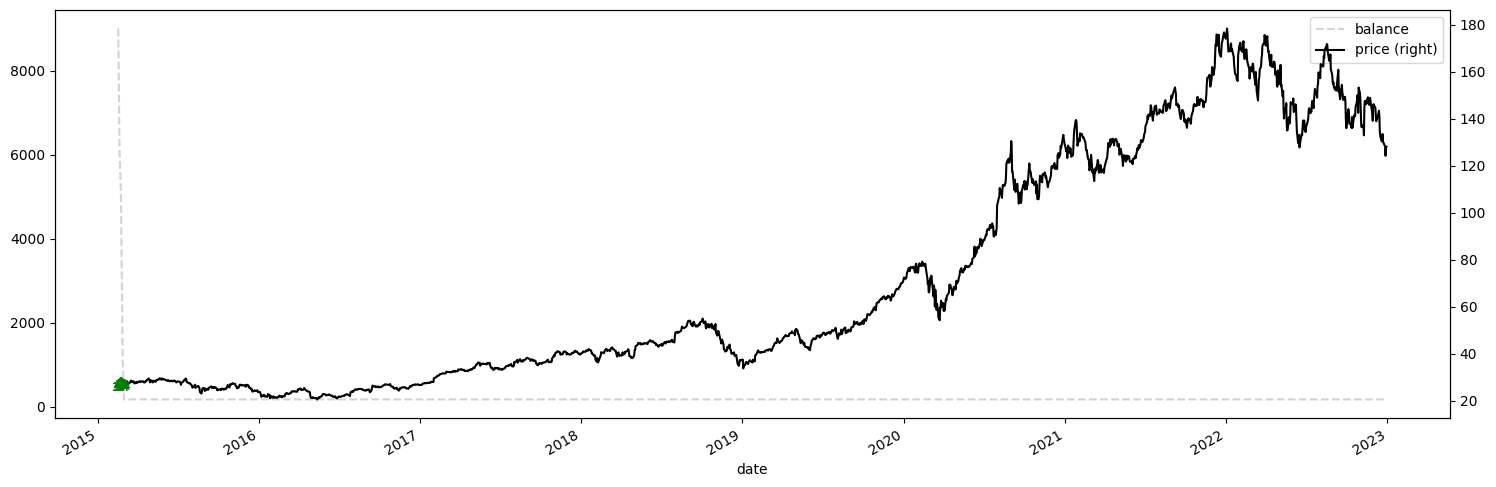

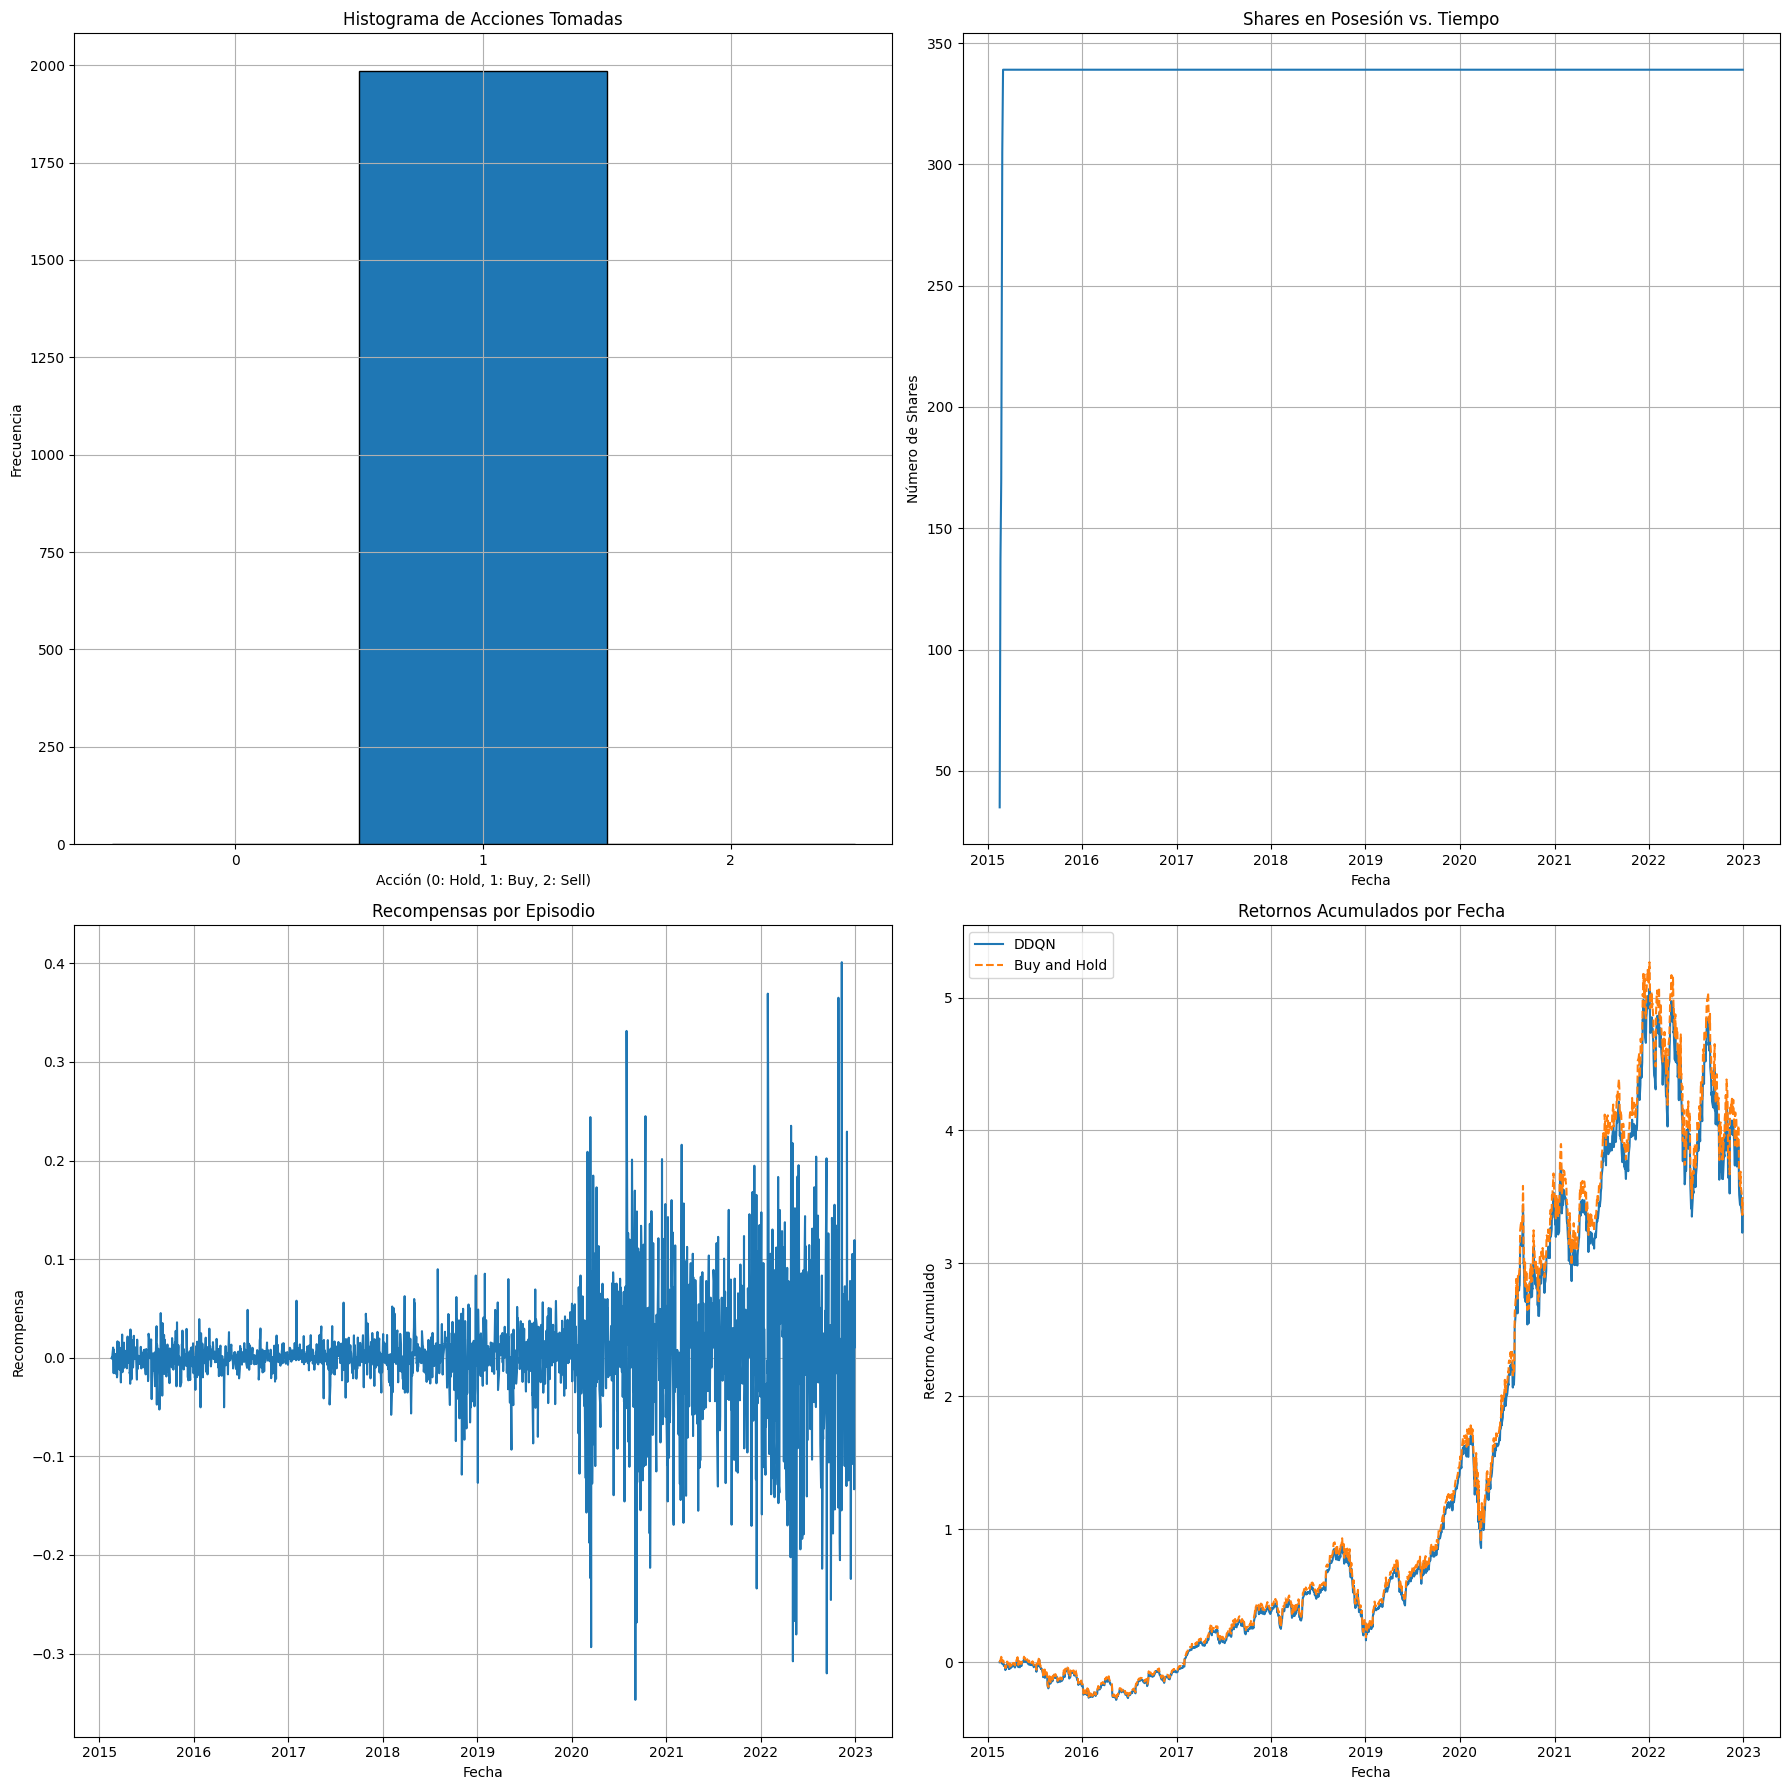

In [17]:
train_results = eval_agent(train_data)

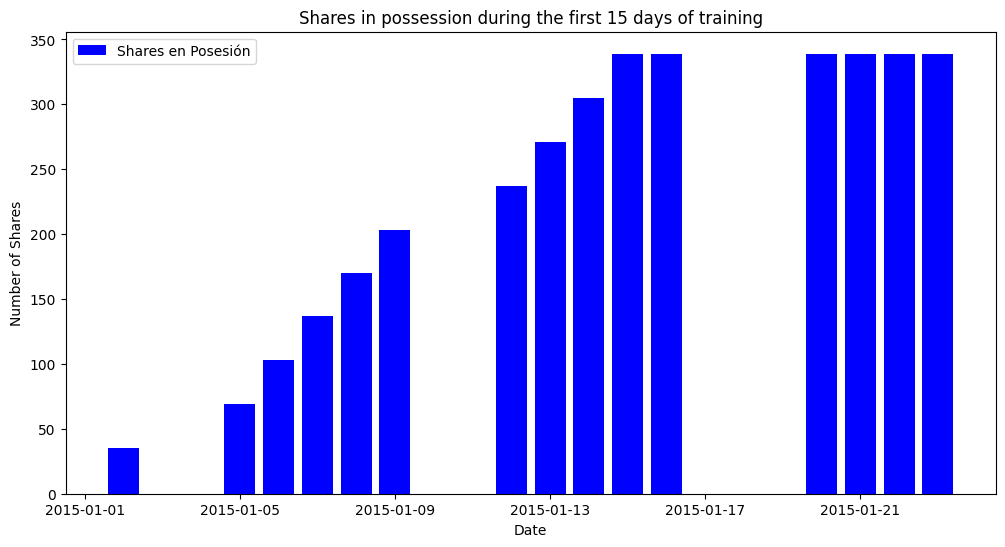

In [18]:
ndays = 15

plt.figure(figsize=(12, 6))
plt.bar(train_data.index[:ndays], train_results[1][:ndays], label='Shares en Posesión', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Shares')
plt.title(f'Shares in possession during the first {ndays} days of training')
plt.legend()
plt.show()

**OBSERVACIONES**:
- Vemos que la estrategia adoptada por el algoritmo fue básicamente compar y mantener, agotando el cupo diario hasta consumir todo el capital disponible para inversión.

- Está estrategia tiene lógica considerando que durante el período de entrenamiento se vio una gran apreciación de la acción tomada como benchmark y la estrategia de "buy and hold" evidentemente dio grandes frutos.

- Esto último también estuvo motivado por el hecho de que, por cada movimiento de "buy" o "sell", la recompensa se veia implicitamente penalizada por comisiones y el spread entre compra-venta.

- Si bien se penalizó la opción mantener en el cálculo de la recompensa, vemos que el modelo encontro la forma de by-passearla eligiendo la opción comprar pero no ejecutandose al no contar con liquidez. Se podría instar al agente a no hacer esto penalizando en caso de que opte por comprar cuando no tenga suficiente liquidez.

- Se observa que a pesar de haber consumido todo el capital, el agente seguía recomendando comprar, lo cual viendo el gráfico de evolución del precio que tiene una clara tendencia alcista, era correcto durante los primeros instantes de tiempo, pero no logro captar las caídas locales como para recomendar vender en esos breves períodos y así optimizar la ganancia.

- Se observa que en la evolución de la recompensa con los episodios, los picos de caída coinciden con los de baja de precio de la acción. Esto esta relacionado con el hecho de que en parte la recompensa depende de la variación del precio de la acción, la cual esta fuera del rango de acción del agente y es inmanejable, dificultando el entrenamiento y dando cuenta de la complejidad del problema.

- Se debería explorar con la incorporación de otros indicadores técnicos para definir el estado del ambiente en un instante dado. Otra opción sería reemplazar la ventana de precios reales como información del estado por valores más suaves como puede ser la ventana de alguna media móvil.

- Se debería explorar también el ajuste de hiper-parámetros y tomar otros papeles como benchamark para continuar con la evaluación del modelo.


#### 2.6 TESTEO

Se evalua la perfomance del agente entrenado contra los datos de testeo no vistos.

Acciones: {0: 0, 1: 629, 2: 0}
Recompensa total: 0.545522506512452
Valor neto final: 15455.225065124518
Valor neto Buy and Hold: 15015.16120910645


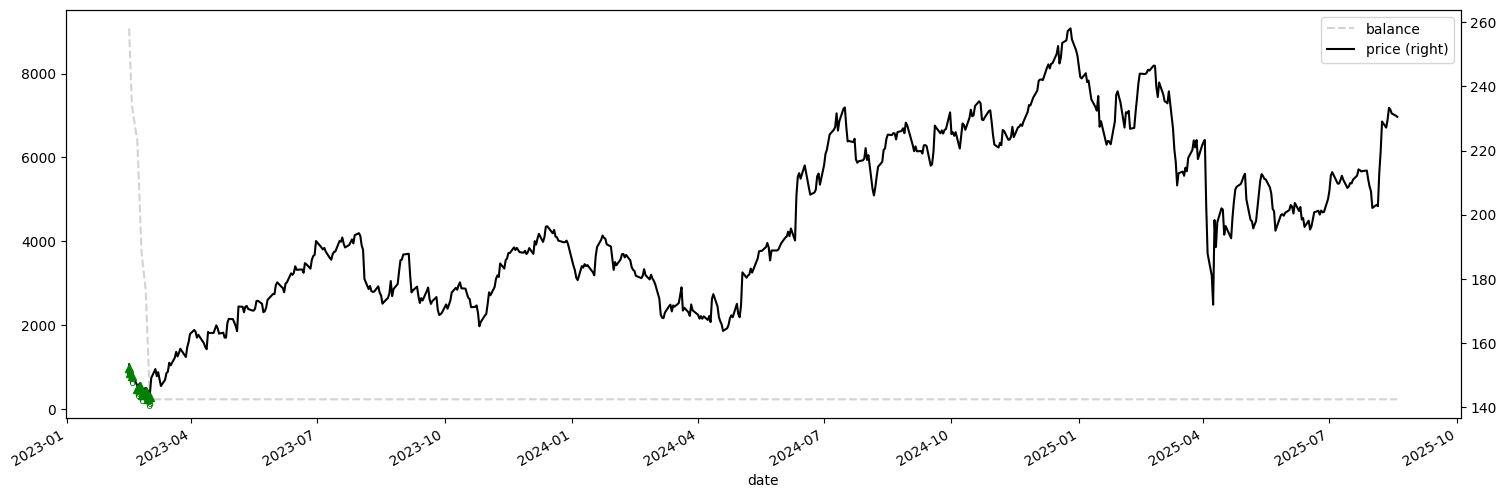

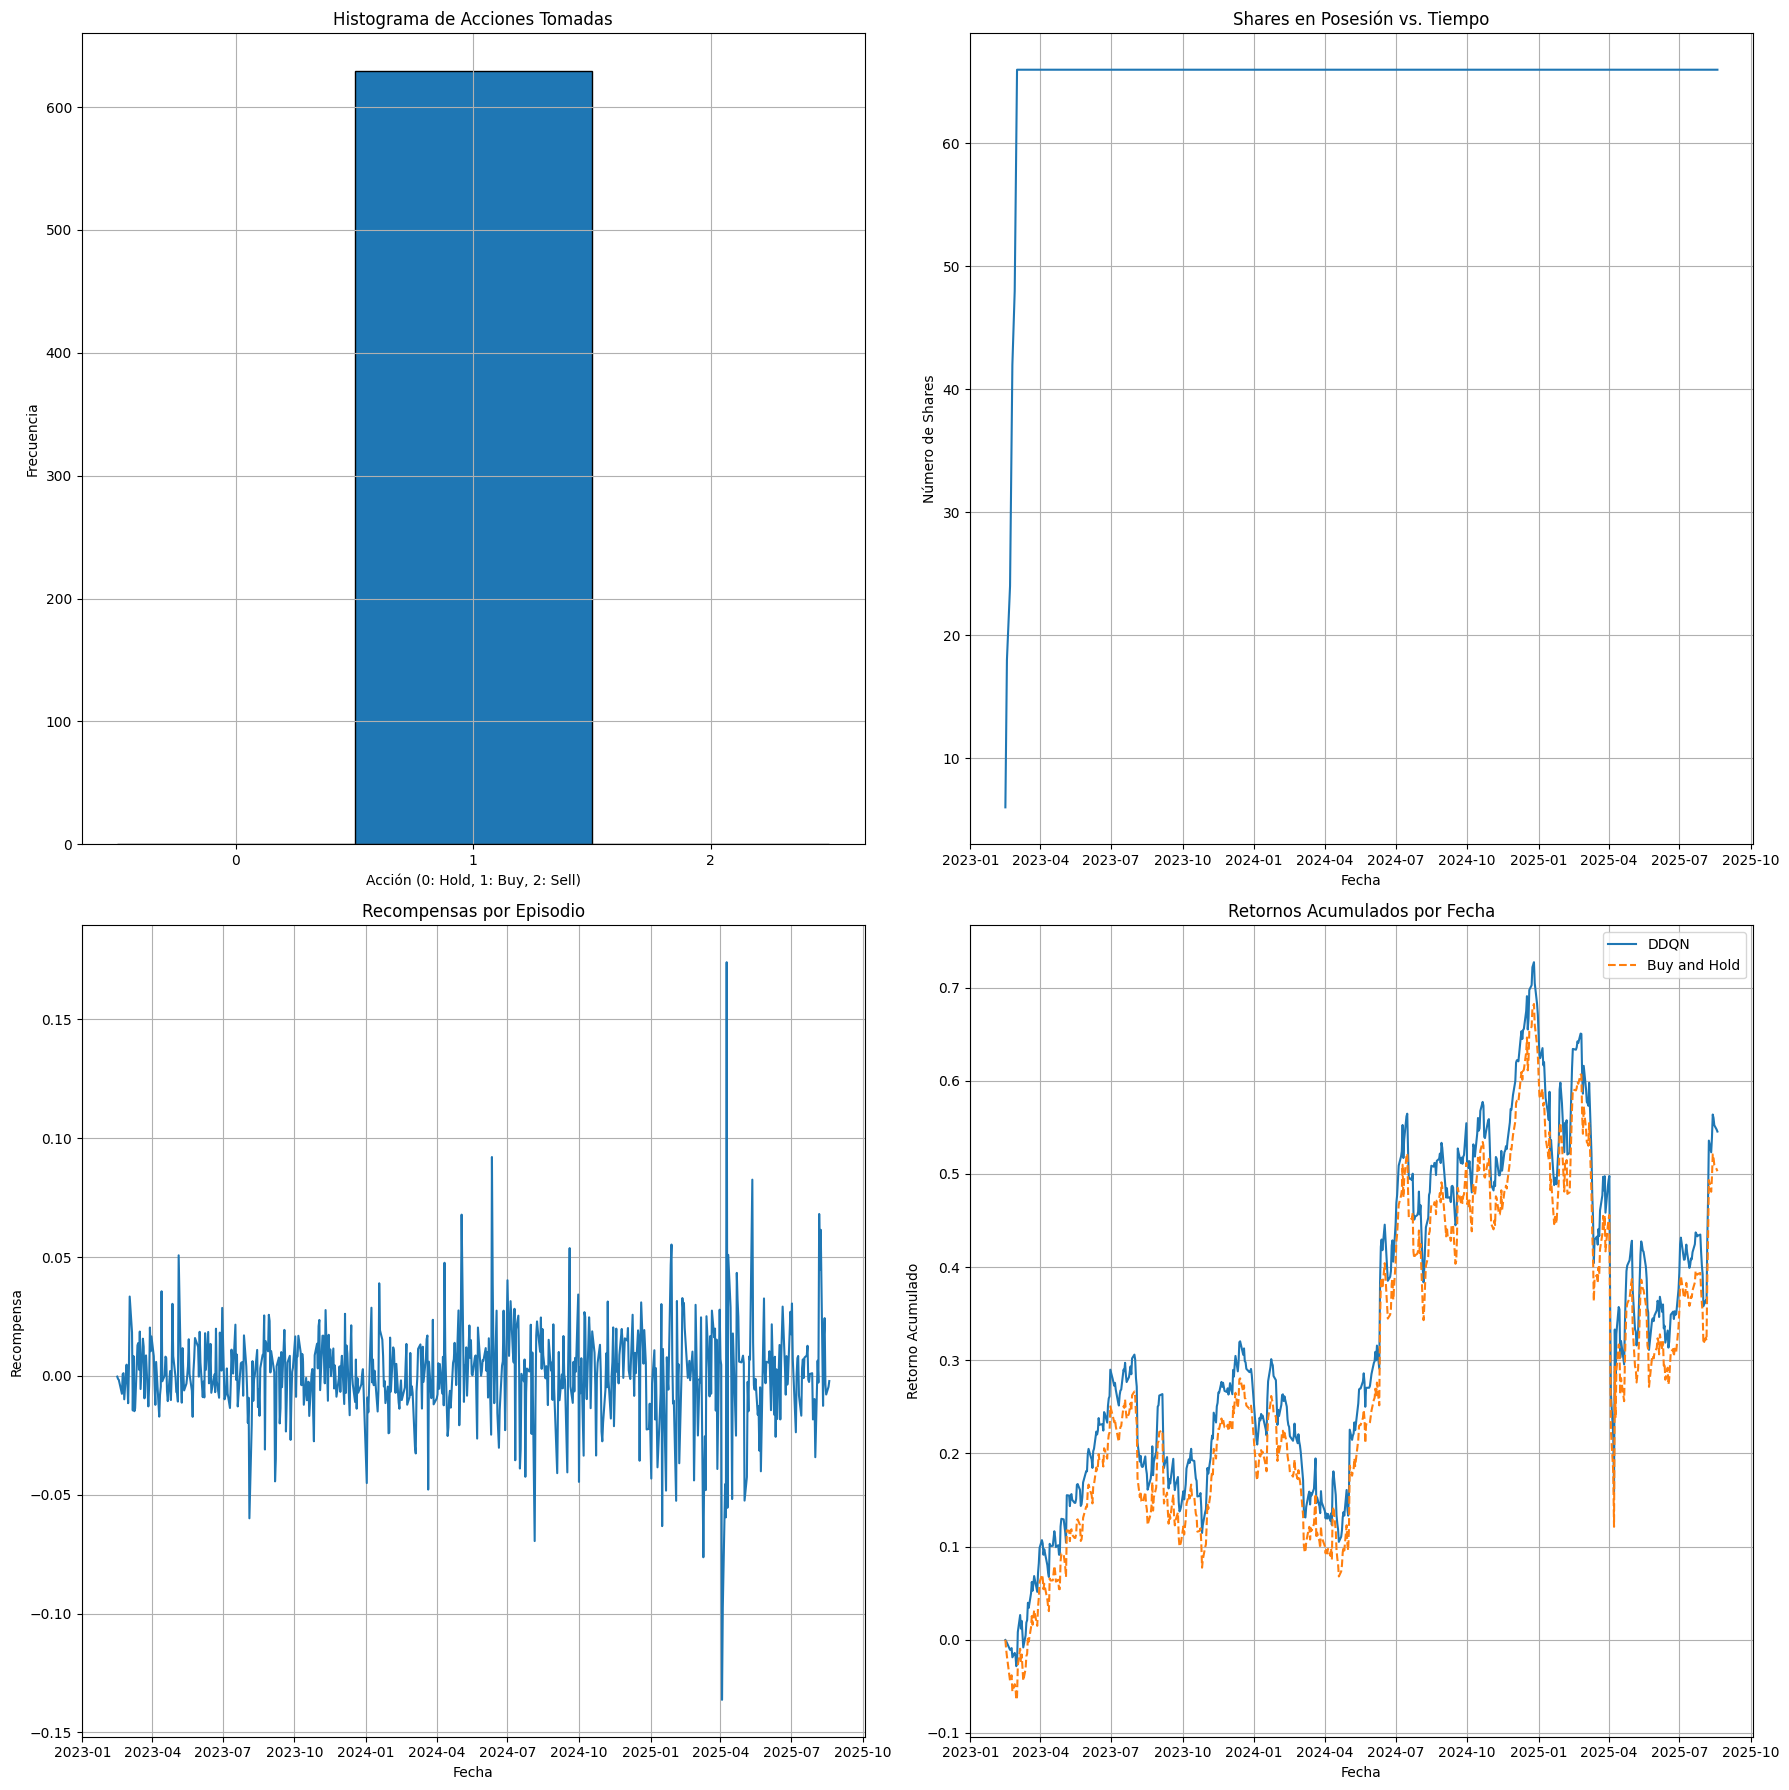

In [19]:
test_results = eval_agent(test_data)

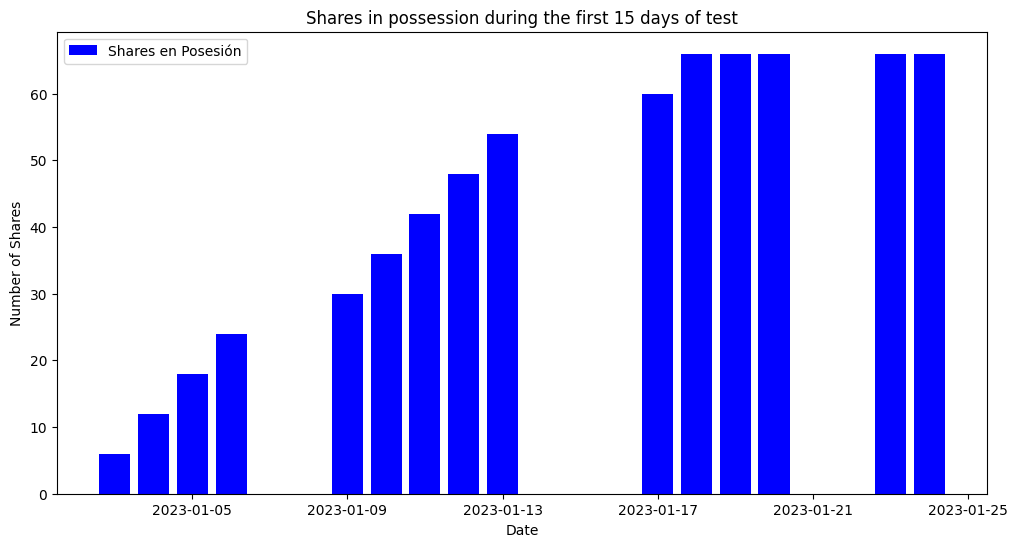

In [15]:
ndays = 15

plt.figure(figsize=(12, 6))
plt.bar(test_data.index[:ndays], test_results[1][:ndays], label='Shares en Posesión', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Shares')
plt.title(f'Shares in possession during the first {ndays} days of test')
plt.legend()
plt.show()

### 3. CONCLUSIONES

- **Estrategia de Compra y Retención:** El agente DDQN adoptó una estrategia de comprar y retener, efectiva por la tendencia alcista de AAPL (2015-2025), pero no aprovechó caídas temporales para optimizar ganancias.

- **Diseño del Entorno:** El entorno simulado con Gymnasium reflejó bien el mercado, pero la función de recompensa, ligada a cambios de precios, fue sensible a la volatilidad, dificultando el entrenamiento.

- **Limitaciones:** El agente no detectó correcciones de precios a corto plazo debido a una representación de estado limitada (precios crudos y pocos indicadores). También explotó un fallo al elegir "comprar" sin liquidez.

- **Datos y Entrenamiento:** Los datos de AAPL (80/20 train-test) fueron adecuados, pero el enfoque en un solo activo sesgó al agente hacia comprar y retener, limitando su generalización.

**Mejoras:**

- Penalizar acciones inválidas (comprar sin liquidez).
- Incluir más indicadores técnicos (MACD, Bandas de Bollinger) o datos suavizados (medias móviles).
- Probar con otros activos y condiciones de mercado.
- Ajustar hiperparámetros y la función de recompensa para reducir dependencia de la volatilidad.


**Implicaciones:** El proyecto muestra el potencial de RL en finanzas, pero requiere mejoras en la robustez y adaptabilidad del modelo.

**Recomendaciones:** Refinar la recompensa, ampliar el estado con indicadores, probar con más activos y explorar otros algoritmos RL